# Adversarial Examples: a simple demo on MNIST with a 4-layer concolutional neural network (CNN)

Adversarial examples are slight perturbed inputs in a way to fool a neural network.

Here is the famous "panda->gibbon" example:

<img src="images/adversarial_example.jpg" width="600">

This demo shows how to train a simple deep neural network and trick the network with adversarial examples. A simple 4 layer neural network will be trained to recognize handwritten digits (MNIST). We then will use the Fast Gradient Sign Mehtod (FGSM) to craft adversarial examples based on a test image.

<img src="images/mnist_advs.png" width="600">

(The demo is implemented by Daniel (Xingjun) Ma for [AI2019 Adversarial Machine Learning Tutorial](http://nugget.unisa.edu.au/AI2019/index.php).

# Load dataset
### Load MNIST data

In [27]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### reshape to (n_samples, 28, 28, 1)

In [28]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

### cast pixels to floats, normalize to [0, 1] range

In [29]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = (X_train / 255.0)
X_test = (X_test / 255.0)

### one-hot encoding the class labels

In [30]:
from keras.utils import np_utils
# one-hot encoding the class labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [31]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test", Y_test.shape)

X_train: (60000, 28, 28, 1)
Y_train: (60000, 10)
X_test: (10000, 28, 28, 1)
Y_test (10000, 10)


# Build a 4-layer convolutional nerual network
### Create the network

In [57]:
# load the keras layers
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, \
    Flatten, Activation, BatchNormalization, Activation, AvgPool2D
from keras.models import Model

img_input = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal", name='conv1')(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(x)

x = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal", name='conv2')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(x)

x = Flatten(name='flatten')(x)

x = Dense(128, kernel_initializer="he_normal", name='features')(x)

x = Dense(10, name='logits')(x)
x = Activation("softmax")(x)

model = Model(img_input, x)

### Check the structure of the network

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (AveragePooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 64)        256       
__________

### Create the optimizer

In [34]:
from keras.optimizers import Adam, SGD
# optimizer = SGD(lr=0.01, decay=1e-4, momentum=0.9)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

### Compile the model

In [58]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

### Train the model for 10 epochs with batch size 128

In [36]:
model.fit(X_train, Y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 162s 3ms/step - loss: 0.1634 - acc: 0.9491 - val_loss: 0.0729 - val_acc: 0.9766
Epoch 2/10
60000/60000 [==============================] - 143s 2ms/step - loss: 0.0599 - acc: 0.9817 - val_loss: 0.0511 - val_acc: 0.9833
Epoch 3/10
60000/60000 [==============================] - 144s 2ms/step - loss: 0.0457 - acc: 0.9859 - val_loss: 0.0381 - val_acc: 0.9881
Epoch 4/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0385 - acc: 0.9879 - val_loss: 0.0402 - val_acc: 0.9876
Epoch 5/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0336 - acc: 0.9897 - val_loss: 0.0359 - val_acc: 0.9877
Epoch 6/10
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0300 - acc: 0.9907 - val_loss: 0.0339 - val_acc: 0.9883
Epoch 7/10
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0260 - acc: 0.9921 - val_loss: 0.0301 - 

### Save/load the trained model

In [59]:
# model.save_weights('model/mnist.h5')
model.load_weights('model/mnist.h5')

### Evaluate the model

In [39]:
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)

In [41]:
print('Test accuracy: %.2f' % test_acc)

Test accuracy: 0.99


# Craft adversarial examples using Fast Gradient Sign Method (FGSM) attack
### Define TF placeholders for the input and output

In [42]:
import tensorflow as tf
x_test = tf.placeholder(tf.float32, shape=(None,) + X_test.shape[1:])
y_test = tf.placeholder(tf.float32, shape=(None,) + Y_test.shape[1:])

### Use cleverhans [https://github.com/tensorflow/cleverhans]

In [44]:
import keras.backend as K
from cleverhans.evaluation import batch_eval
from cleverhans.attacks import FastGradientMethod

### Wrap the model for cleverhans

In [92]:
from cleverhans.utils_keras import KerasModelWrapper
model = KerasModelWrapper(model)

In [63]:
X_test.shape

(10000, 28, 28, 1)

In [93]:
print('Crafting fgsm adversarial samples...')

fgsm = FastGradientMethod(model)
fgsm_params = {'eps': 0.3,
               'clip_min': 0,
               'clip_max': 1}

adv_x = fgsm.generate(x_test, **fgsm_params)

X_adv, = batch_eval(sess=K.get_session(), tf_inputs=[x_test, y_test], tf_outputs=[adv_x],
                    numpy_inputs=[X_test, Y_test], batch_size=100)

print('Done')

Crafting fgsm adversarial samples...
Done


### predict the adversarial labels

In [95]:
model = model.model
predictions = model.predict(X_adv, batch_size=100, verbose=0)
y_pred = np.argmax(predictions, axis=1)
Y_adv = np_utils.to_categorical(y_pred, 10)

### Save adversarial examples and labels into local files

In [96]:
np.save('data/advs_fgsm.npy', X_adv)
np.save('data/labels_advs_fgsm.npy', Y_adv)

### check predictions on adversarial examples

In [97]:
# model = model.model # switch back to normal model from KerasModelWrapper
_, acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print("Accuracy on clean test set: %0.2f%%" % (100*acc))

# statistics of the attacks
_, acc = model.evaluate(X_adv, Y_test, batch_size=100, verbose=0)
print("Model accuracy on the adversarial test set: %0.2f%%" % (100 * acc))


Accuracy on clean test set: 99.06%
Model accuracy on the adversarial test set: 4.28%


### check average L2 perturbation

In [98]:
l2_diff = np.linalg.norm(
    X_adv.reshape((len(X_test), -1)) -
    X_test.reshape((len(X_test), -1)),
    axis=1
).mean()
print("Average L-2 distortion [%s: %0.2f]" % ('FGSM', l2_diff))


Average L-2 distortion [FGSM: 6.24]


### check $L_{\infty}$ perturbation

In [99]:
li_diff = np.max(
    np.abs(
        X_adv.reshape((len(X_test), -1)) -
        X_test.reshape((len(X_test), -1))),
        axis=0
).mean()
print("Average L-i distortion [%s: %0.2f]" % ('FGSM', li_diff))



Average L-i distortion [FGSM: 0.30]


# Visualize adversarial examples
### clean vs advs

In [100]:
# define source -> target classes
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
target_classes = ['3', '9', '3', '0', '5', '8', '8', '9', '5', '7']

<Figure size 1080x288 with 0 Axes>

In [111]:
# one-hot to integer labels
clean_labels = np.argmax(Y_test, axis=1)
adv_labels = np.argmax(Y_adv, axis=1)

In [112]:
adv_labels

array([8, 8, 8, ..., 8, 8, 8])

selected random samples:  [7887, 6254, 1335, 5724, 4258, 4302, 2160, 144, 9817, 7535]
[0 1 2 3 4 5 6 7 8 9]
[9 8 1 8 8 3 5 3 6 8]

Saving figure


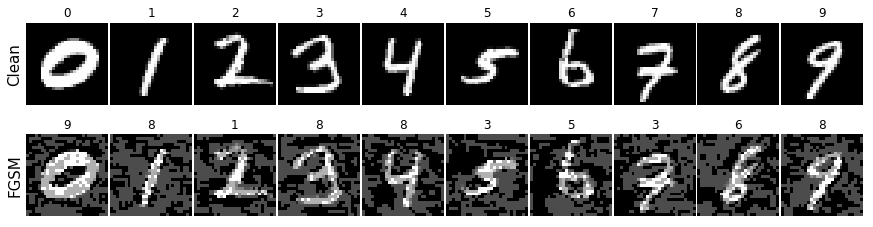

In [135]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# image properties
dataset = 'mnist'
attack = 'FGSM'
n_classes = 10
n_channels = 1
image_size = 28

# find one random image index for each class
sample_idxes = []
for i in range(n_classes):
    ind, = np.where(clean_labels == i)
    select = np.random.choice(ind, size=1)
    sample_idxes.append(select[0])
print('selected random samples: ', sample_idxes)
print(clean_labels[sample_idxes])
print(adv_labels[sample_idxes])

%matplotlib inline
# creat the grid plot
fig = plt.figure(figsize=(1.5*n_classes, 4))
gs = gridspec.GridSpec(2, n_classes, wspace=0.025, hspace=0.05)

## plot normal images
for i in range(n_classes):
    ax = fig.add_subplot(gs[0, i])
    img = X_test[sample_idxes[i]]
    label = classes[i]
    # deal with normalized images [-0.5, 0.5] - already buildin in matplot?
    img = img + 0.5
    if n_channels == 1:
        img = np.reshape(img, (image_size,image_size))
        ax.imshow(img, cmap='gray')
    else:
        img = np.reshape(img, (image_size, image_size, n_channels))
        ax.imshow(img)

    if ax.is_first_col():
        ax.set_ylabel('Clean', fontsize=15)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label, fontsize=12)

## plot advs images
for j in range(n_classes):
    img = X_adv[sample_idxes[j]]
    label = classes[adv_labels[sample_idxes[j]]]

    ax = fig.add_subplot(gs[1, j])
    img = img + 0.5
    if n_channels == 1:
        img = np.reshape(img, (image_size, image_size))
    else:
        img = np.reshape(img, (image_size, image_size, n_channels))

    if n_channels == 1:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)

    if ax.is_first_col():
        ax.set_ylabel(attack, fontsize=15)

    ax.set_title(label, fontsize=12)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

print('\nSaving figure')
# gs.tight_layout(fig) # don't use this - this will writeoff wspace/hspace settings
fig.savefig("images/%s_%s_clean_advs.png" % (dataset, attack), dpi=300)
plt.show()